# fasttext

In [26]:
# fasttext
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import random
import fasttext
import jieba
from sklearn.model_selection import train_test_split

def loadData():
    #利用pandas把数据读进来
    text_df = pd.read_csv("Workspace-of-NLU/corpus/clf/jingling-simple.csv",encoding ="utf-8", usecols=[0])
    label_df = pd.read_csv("Workspace-of-NLU/corpus/clf/jingling-simple.csv",encoding ="utf-8", usecols=[1])
    text_list = np.array(text_df)
    label_list = np.array(label_df)

    return text_list, label_list

# 加载数据
text_list, label_list = loadData()

label_dict = {}
label_dict_idx2str = {}
label_list = [ item[0] for item in label_list ]
text_list = [ item[0] for item in text_list ]

label_set = set(label_list)
label_dict_list = list(label_set)

for idx, item in enumerate(label_dict_list):
    label_dict[item] = '__label__' + str(idx)
    label_dict_idx2str[idx] = item

print(label_dict)

train_text, test_text, train_label, test_label = train_test_split(text_list, label_list, test_size=0.2, random_state=42)

# 添加噪声
text_noise, label_noise = [], []
for i in range(4000):
    text_noise.append(random.choice(test_text))
    label_noise.append(random.choice(test_label))
test_text = test_text + text_noise
test_label = test_label + label_noise

with open("train.data", 'w', encoding='utf-8') as f:
    for text, label in zip(train_text, train_label):
        f.write(label_dict[str(label)] + '\t' +  " ".join(jieba.cut(str(text))) + '\n')

with open("test.data", 'w', encoding='utf-8') as f:
    for text, label in zip(test_text, test_label):
        f.write(label_dict[str(label)] + '\t' + " ".join(jieba.cut(str(text))) + '\n')


{'配送时效': '__label__0', '企业金库': '__label__1', '拼购订单': '__label__2', '品牌聚效展位': '__label__3', '平台活动': '__label__4', '钱包账单': '__label__5', '品牌管理': '__label__6', '入驻费用': '__label__7', '赔付咨询': '__label__8', '拼购活动促销': '__label__9'}


In [4]:

import fasttext

model = fasttext.train_supervised(input='train.data', epoch=5, lr=1.0, wordNgrams=2, verbose=2, minCount=1)
result = model.test_label('test.data')
print(type(result))
print(result)
model.save_model("model.bin")



<class 'dict'>
{'__label__3': {'precision': 0.6690909090909091, 'recall': 0.6174496644295302, 'f1score': 0.6422338568935427}, '__label__7': {'precision': 0.4, 'recall': 0.5, 'f1score': 0.4444444444444444}, '__label__4': {'precision': 0.6794185156847743, 'recall': 0.6910505836575875, 'f1score': 0.6851851851851852}, '__label__1': {'precision': 0.6798866855524079, 'recall': 0.676056338028169, 'f1score': 0.6779661016949152}, '__label__9': {'precision': 0.6776034236804565, 'recall': 0.6747159090909091, 'f1score': 0.6761565836298933}, '__label__0': {'precision': 0.705229793977813, 'recall': 0.7112413425679276, 'f1score': 0.7082228116710876}, '__label__6': {'precision': 0.7325864588407209, 'recall': 0.7182425978987583, 'f1score': 0.7253436218953461}, '__label__2': {'precision': 0.7039274924471299, 'recall': 0.6657142857142857, 'f1score': 0.684287812041116}, '__label__8': {'precision': 0.6528117359413202, 'recall': 0.638755980861244, 'f1score': 0.6457073760580411}, '__label__5': {'precision': 

In [5]:
n_class = 10

In [6]:
def get_prob_results(text):
    single_result = model.predict(" ".join(jieba.cut(text)), k=n_class)
    prob_results = [0]*n_class
    for label, value in zip(single_result[0], single_result[1]):
        idx = int(label.split("__")[2])
        prob_results[idx] = value
    return prob_results

all_prob_results = []
for text in test_text:
    all_prob_results.append(get_prob_results(str(text)))

12000
12000
outputs [2, 6, 5, 9, 3, 5, 5, 0, 5, 6]
grounds [2, 6, 5, 9, 3, 5, 5, 0, 5, 6]


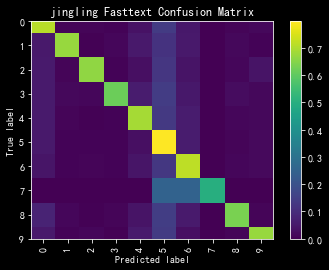

In [7]:
# y = np.array([1,2,3,4])
# convert_to_one_hot(y,5)

import sklearn
import matplotlib.pyplot as plt

outputs = [ np.argmax(item) for item in all_prob_results]
grounds = [ int(label_dict[item].split("__")[2]) for item in test_label ]

print(len(outputs))
print(len(grounds))

print("outputs", outputs[:10])
print("grounds", grounds[:10])

# confusion matrix


cm = sklearn.metrics.confusion_matrix(
    grounds,   # array, Gound true (correct) target values
    outputs,  # array, Estimated targets as returned by a classifier
    labels=None,  # array, List of labels to index the matrix.
    sample_weight=None  # array-like of shape = [n_samples], Optional sample weights
)

def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, list(range(n_class)), "jingling Fasttext Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()

In [8]:
## p
print("precision")
from sklearn.metrics import precision_score
print(precision_score(grounds, outputs, average='macro'))  
print(precision_score(grounds, outputs, average='micro'))  
print(precision_score(grounds, outputs, average='weighted'))
print(precision_score(grounds, outputs, average=None))

## r
print("recall")
from sklearn.metrics import recall_score
print(recall_score(grounds, outputs, average='macro'))  
print(recall_score(grounds, outputs, average='micro'))  
print(recall_score(grounds, outputs, average='weighted'))
print(recall_score(grounds, outputs, average=None))

## pr 曲线

## f1
print("f1")
from sklearn.metrics import f1_score
print(f1_score(grounds, outputs, average='macro'))  
print(f1_score(grounds, outputs, average='micro'))  
print(f1_score(grounds, outputs, average='weighted'))
print(f1_score(grounds, outputs, average=None))

## classification_report
# from sklearn.metrics import classification_report
# classification_report(grounds, outputs, target_names=[ str(item) for item in list(range(107))])

precision
0.6688699676032994
0.73425
0.733893697747296
[0.70522979 0.67988669 0.70392749 0.66909091 0.67941852 0.78814466
 0.73258646 0.4        0.65281174 0.67760342]
recall
0.6691276539734867
0.73425
0.73425
[0.71124134 0.67605634 0.66571429 0.61744966 0.69105058 0.79804984
 0.7182426  0.5        0.63875598 0.67471591]
f1
0.6682614115649661
0.73425
0.7339941572410289
[0.70822281 0.6779661  0.68428781 0.64223386 0.68518519 0.79306632
 0.72534362 0.44444444 0.64570738 0.67615658]


(12000, 10)
(12000, 10)


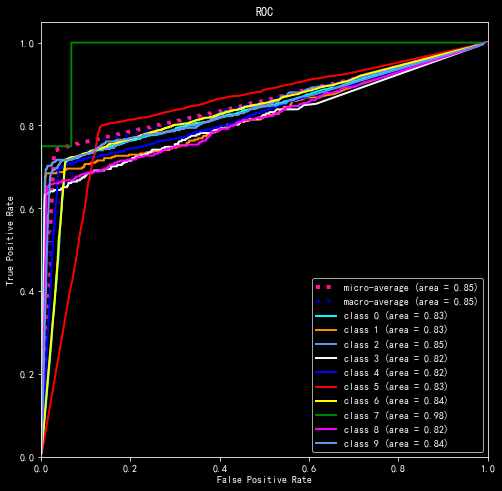

In [9]:
# 多分类ROC
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

tmp = [0]*n_class
tmp = [tmp] * len(grounds)
y_test = []
for idx, vector in enumerate(tmp):
      tmp_vector = vector.copy()
      tmp_vector[grounds[idx]]=1
      y_test.append(tmp_vector)
tmp = []

y_test = np.asarray(y_test)
y_score = np.asarray(all_prob_results)

# print("y_test", y_test[:10])
# print("predicts", y_score[:10])

# 计算每一类的ROC
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()

print(y_test.shape)
print(y_score.shape)

# class
for i in range(n_class):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_score[:, i])

    roc_auc[i] = auc(fpr[i], tpr[i])
    # print("i", i, "thresholds", thresholds[i][:20])
    # print("auc", roc_auc[i])
    # print("fpr", fpr[i][:20])
    # print("tpr", tpr[i][:20])

# micio
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# marco
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_class):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'aliceblue', 'blue', 'red', 'yellow', 'green', 'fuchsia', 'cornflowerblue'])
for i, color in zip(range(n_class), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
      # plt.plot([0, 1], [0, 1], 'k--', lw=lw)
      # plt.xlim([0.0, 1.0])
      # plt.ylim([0.0, 1.05])
      # plt.xlabel('False Positive Rate')
      # plt.ylabel('True Positive Rate')
      # plt.title('ROC')
      # plt.legend(loc="lower right")
      # plt.show()

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


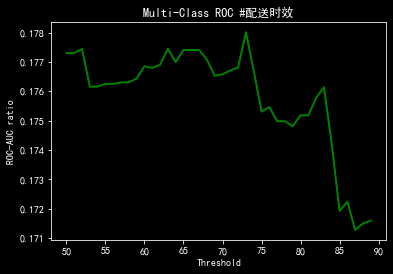

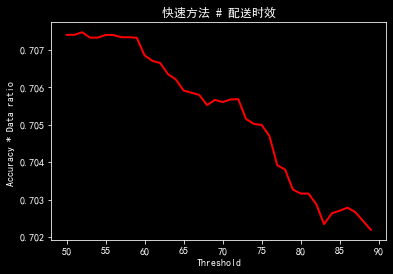

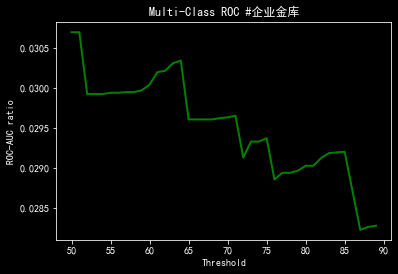

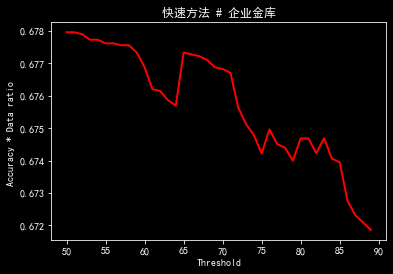

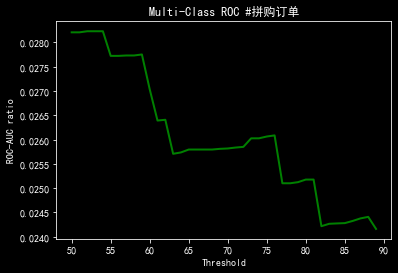

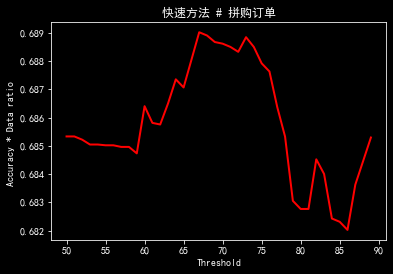

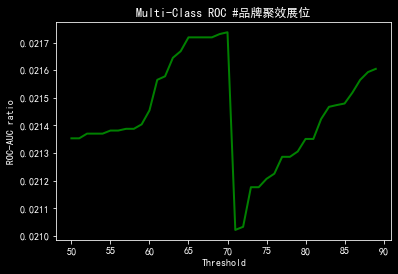

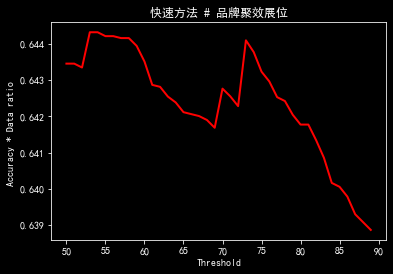

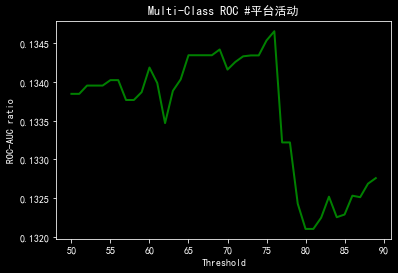

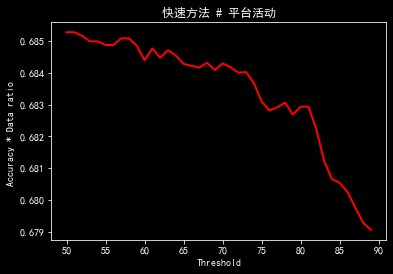

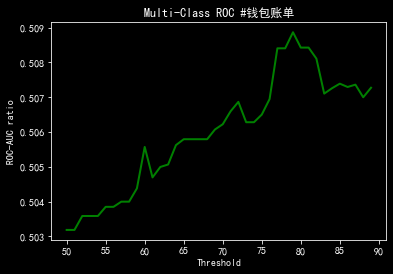

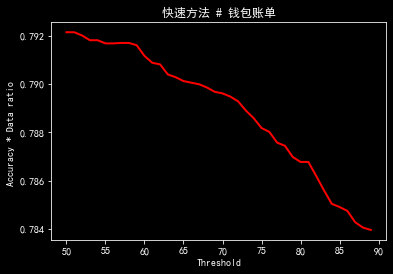

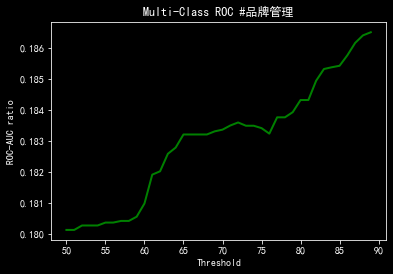

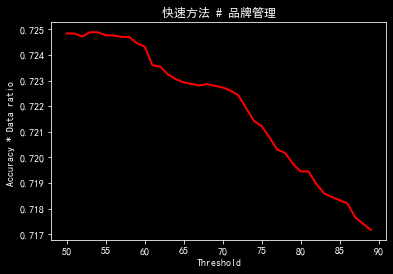

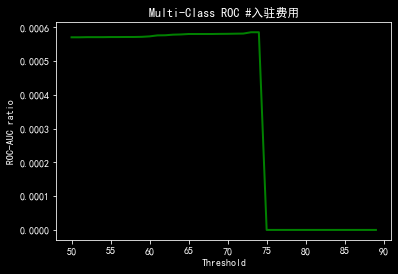

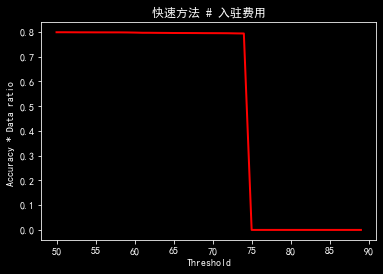

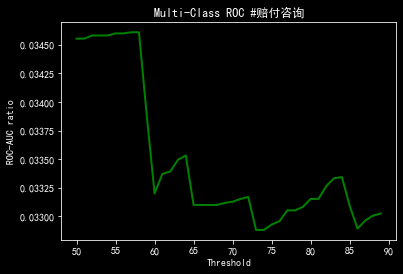

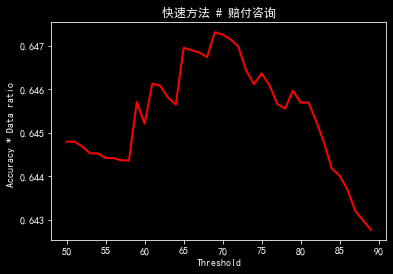

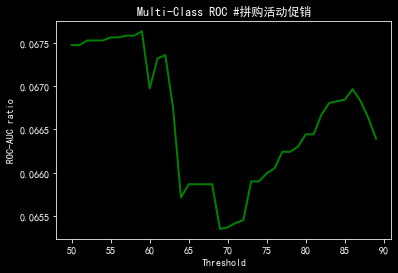

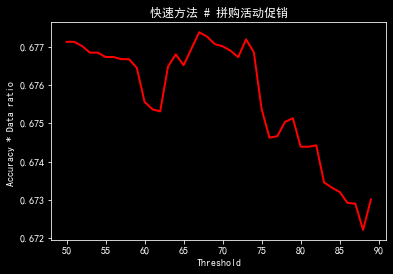

In [28]:
# 设定阈值之后数据的结果
def new_fpr_tpr(i, value):
    return_tpr, return_fpr = tpr[i].copy(), fpr[i].copy() 

    #return_fpr = [return_fpr[idx] if thresholds[i][idx] > value else 0 for idx in range(len(return_fpr))]
    return_tpr = [return_tpr[idx] if thresholds[i][idx] < value else 0 for idx in range(len(return_tpr))]

    return return_fpr.copy(), return_tpr.copy()

def calculate_vip(value, vip_calss=[class_id]):
    tmp_auc_list = []
    for i in range(n_class):
        tmp_fpr, tmp_tpr = new_fpr_tpr(i, value)
        all_auc = auc(fpr[i], tpr[i])
        # print("all_auc", all_auc)
        tmp_auc = auc(tmp_fpr, tmp_tpr)
        # print("tmp_auc", tmp_auc)
        cut_auc = all_auc - tmp_auc
        # print("cut_auc", cut_auc)
        tmp_auc_list.append(cut_auc)

    key_auc_all = 0
    for idx in vip_calss:
        key_auc_all += tmp_auc_list[idx]

    auc_all = 0
    tmp_auc_list = tmp_auc_list[1:]
    for value in tmp_auc_list :
        auc_all += value
    
    if auc_all == 0:
        return 0
    else:
        # print("key", key_auc_all)
        # print("all", auc_all)
        # print(key_auc_all/auc_all)
        
        return key_auc_all/auc_all

def thresholds_main(vip_calss):
    max_vip = 0
    return_threshold = 0
    ratio_list = []
    for threshold_value in range(50, 90, 1):
        threshold_value = threshold_value/100
        tmp_vip = calculate_vip(threshold_value, vip_calss)
        
        ratio_list.append(tmp_vip)
        if tmp_vip > max_vip:
            max_vip = tmp_vip 
            return_threshold = threshold_value

    return ratio_list, return_threshold

length = len(y_test)

for class_id in range(10):
    ratio_list, best_threshold = thresholds_main([class_id])
    # print(ratio_list)
    
    plt.plot(list(range(50, 90, 1)), ratio_list, lw=lw, color='green')
    plt.xlabel('Threshold')
    plt.ylabel('ROC-AUC ratio')
    plt.title('Multi-Class ROC #' + label_dict_idx2str[class_id])
    plt.show()

    result_list = []
    for value in range(50, 90, 1):
        value = value/100
        outputs_tmp = [ np.argmax(item_1) for item_1, item_2 in zip(y_score, y_test) if max(item_1) > value ]
        grounds_tmp = [ np.argmax(item_2) for item_1, item_2 in zip(y_score, y_test) if max(item_1)  > value ]

        from sklearn.metrics import f1_score, precision_score, recall_score
        tmp_result = f1_score(grounds_tmp, outputs_tmp, average=None)[class_id] * len(outputs_tmp) / length
        result_list.append(tmp_result)
    # print(result_list)
    plt.plot(list(range(50, 90, 1)), result_list, lw=lw, color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy * Data ratio ')
    plt.title('快速方法 # ' + label_dict_idx2str[class_id])
    plt.show()